## Forecast validation for Euclid cosmological probes: Fisher Matrix
Student: Antonia Cisternas \
Teacher: Domenico Sapone

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats, interpolate
import sympy
from scipy.integrate import cumtrapz, solve_ivp, odeint, quadrature, dblquad
import autograd.numpy as np
from autograd import grad


### Fiducial parameters

The number density in each redshift bin is given by:
$$
n(z) = \frac{dN(z)}{d\Omega dz} \frac{A_{survey}}{V_s(z)} \Delta z
$$

In [2]:
# Based on table 3 of the page 14:
V_s = [7.94 * 10**(9), 9.15* 10**(9), 10.05* 10**(9), 16.22* 10**(9)] 

# galazy bias factor
b = [1.4614804, 1.6060949, 1.7464790, 1.8988660]

# Centered position of each bin
z_i = [1., 1.2, 1.4, 1.65]
z_min = [0.9, 1.1, 1.3, 1.5]
z_max = [1.1, 1.3, 1.5, 1.8]

In [3]:
#Fiducial parameters
wb = 0.022445
wm = 0.143648
h = 0.67
c = 300.000

Omega_b0 = wb/ (h**2)
H0 = 100 * h
Omega_m0 = wm/ (h**2)
ns = 0.96 # Spectral index of the primordial density power spectrum
Omega_DE0 = 0.68

m_nu = 0.06
w0 = -1
wa = 0

gamma = 0.55

s8_reference= 0.815583

A_surv = 15000 # Survey area
s_z = 0.0001 # Spectroscopic redshift error
P_s = 0 # Shot noise

# Density per unit  área: dN/(dOmega dz)
dn3= [1815.0, 1701.5, 1410.0, 940.97]

# Based on table 3 of the page 14:
# n = [6.86 * 10**(-4), 5.58 * 10**(-4), 4.21* 10**(-4), 2.61 * 10**(-4)]
n = np.zeros_like(z_i)
for i in range(len(z_i)):
    n[i] = dn3[i] * A_surv * (z_max[i] - z_min[i])/ V_s[i]

print('n:', n)


n: [0.00068577 0.00055787 0.0004209  0.00026106]


### Imput files
Archives "Pk-fiducial-z_0_.dat" and "Pknw-fiducial-z_0_.dat" \
Columns: $k$ , $Pk/ s_8^2$ ,  $s_8$

In [4]:
    # For Pk
file_paths = [f"Pk-fiducial/Pk-fiducial-z_0{i}.dat" for i in range(len(z_i))]
Pk_data = [np.loadtxt(file) for file in file_paths]

    # For Pk_nw (no wiggled power spectrum)
file_paths_nw = [f"Pk-nw-fiducial/Pk-nw-fiducial-z_0{i}.dat" for i in range(len(z_i))]
Pk_data_nw = [np.loadtxt(file) for file in file_paths_nw]

    # For the derivatives of Pk and Pk_nw
# Derivatives with negative step (mn) and positive step (pl)
param = ['h', 'ns', 'wb', 'wm']
data_types = ['Pk_data_mn', 'Pk_data_pl', 'Pk_data_nw_mn', 'Pk_data_nw_pl']
data_arrays = {name: np.empty((len(z_i), len(param)), dtype=object) for name in data_types}

for param_index, j in enumerate(param):
  for i in range(len(z_i)):
        data_arrays['Pk_data_mn'][i][param_index] = np.loadtxt(f"Pk-derivative/Pk_{j}_mn_eps_1p0E-2/Pk-{j}_mn_eps_1p0E-2-z_{i:02d}.dat")
        data_arrays['Pk_data_pl'][i][param_index] = np.loadtxt(f"Pk-derivative/Pk_{j}_pl_eps_1p0E-2/Pk-{j}_pl_eps_1p0E-2-z_{i:02d}.dat")
        data_arrays['Pk_data_nw_mn'][i][param_index] = np.loadtxt(f"Pk-nw-derivative/Pk_{j}_mn_eps_1p0E-2/Pk-nw-{j}_mn_eps_1p0E-2-z_{i:02d}.dat")
        data_arrays['Pk_data_nw_pl'][i][param_index] = np.loadtxt(f"Pk-nw-derivative/Pk_{j}_pl_eps_1p0E-2/Pk-nw-{j}_pl_eps_1p0E-2-z_{i:02d}.dat")

# Example: Accessing elements
# To access Pk_data_mn for the bin 0 and the parameter ns:
# example_data = data_arrays['Pk_data_mn'][0][1]

### Interpolation

In [5]:
# Cubic spline interpolation:
# Function to initialize and interpolate data
def initialize_interpolation(data):
    k = np.empty(len(z_i), dtype=object)
    P_ = np.empty(len(z_i), dtype=object)
    k_new = np.empty(len(z_i), dtype=object)

    for i in range(len(z_i)):
        k[i] = np.log(data[i][:, 0])
        P_[i] = interpolate.interp1d(k[i], np.log(data[i][:, 1] * (data[i][:, 2]**2)), kind='cubic')
        k_new[i] = np.log(np.arange(data[i][:, 0][0], data[i][:, 0][-1], 0.0001))
    
    return k, P_, k_new

# Initialize and interpolate data for Pk_data and Pk_data_nw
k, P_dd_, k_new = initialize_interpolation(Pk_data)
k_nw, P_nw_, k_nw_new = initialize_interpolation(Pk_data_nw)

# Functions to get the interpolated power spectrum for a given k and redshift
def P_dd(k, zi):
    i = z_i.index(zi)
    return P_dd_[i](k)

def P_nw(k, zi):
    i = z_i.index(zi)
    return P_nw_[i](k)

For the derivatives with positive and negative steps:

In [6]:
# Function to initialize and interpolate data
def initialize_interpolation(data_key):
    k = np.empty((len(z_i), len(param)), dtype=object)
    P_ = np.empty((len(z_i), len(param)), dtype=object)
    k_new = np.empty((len(z_i), len(param)), dtype=object)

    for j in range(len(param)):
        for i in range(len(z_i)):
            k[i][j] = np.log(data_arrays[data_key][i][j][:, 0])
            P_[i][j] = interpolate.interp1d(k[i][j], np.log(data_arrays[data_key][i][j][:, 1] * (data_arrays[data_key][i][j][:, 2]**2)), kind='cubic')
            k_new[i][j] = np.log(np.arange(data_arrays[data_key][i][j][:, 0][0], data_arrays[data_key][i][j][:, 0][-1], 0.0001))
    
    return k, P_, k_new

# Initialize and interpolate data for each dataset
k_mn, P_mn_, k_mn_new = initialize_interpolation('Pk_data_mn')
k_pl, P_pl_, k_pl_new = initialize_interpolation('Pk_data_pl')
k_nw_mn, P_nw_mn_, k_nw_mn_new = initialize_interpolation('Pk_data_nw_mn')
k_nw_pl, P_nw_pl_, k_nw_pl_new = initialize_interpolation('Pk_data_nw_pl')

# Functions to get the interpolated power spectrum for a given k and redshift
def P_mn(k, zi, j):
    i = z_i.index(zi)
    return P_mn_[i][j](k)

def P_pl(k, zi, j):
    i = z_i.index(zi)
    return P_pl_[i][j](k)

def P_nw_mn(k, zi, j):
    i = z_i.index(zi)
    return P_nw_mn_[i][j](k)

def P_nw_pl(k, zi, j):
    i = z_i.index(zi)
    return P_nw_pl_[i][j](k)

### Graphs of the interpolation

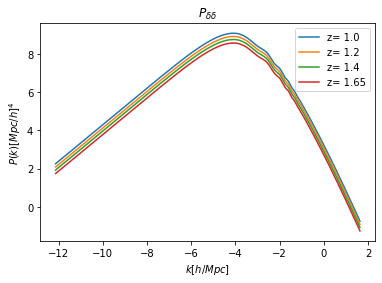

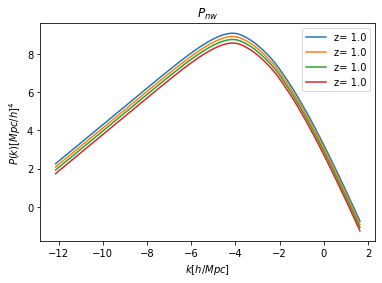

In [7]:
plt.title(r"$P_{\delta \delta}$")
for i in range(0,len(z_i)):
    plt.plot(k_new[i], P_dd_[i](k_new[i]), '-', label= f"z= {z_i[i]}")
plt.xlabel(r"$k[h/Mpc]$")
plt.ylabel(r"$P(k)[Mpc/h]^4$")
plt.legend()
plt.show()

plt.title(r"$P_{nw}$")
for i in range(0,len(z_i)):    
    plt.plot(k_nw_new[0], P_nw_[i](k_nw_new[i]), '-', label= f"z= {z_i[0]}")
plt.xlabel(r"$k[h/Mpc]$")
plt.ylabel(r"$P(k)[Mpc/h]^4$")
plt.legend()
plt.show()


### Sigma 8

In [8]:
def sigma80(z):
    bin = z_i.index(z)
    return Pk_data[bin][0, 2]

### Defining functions

Parámetros a encontrar:
$D_A(z_i)$, $H(z_i)$, $f\sigma_8(z_i)$, $b\sigma_8$ , $P_s(z_i)$, $\omega_{b,0}$, $h$, $\omega_{m,0}$, $n_s$, $\sigma_v (z_{mean})$ y $\sigma_p (z_{mean})$


In [9]:
class Func_of_PS:
    # Put the fiducial parameters ito the args
    def __init__(self):
        #  I never use z_mean
        self.z_mean = (z_max[3]-z_min[0])/2 + z_min[0]

    # For de derivatives with respect to h:
    def Omega_m0(self, wm):
        return wm/ (h**2)
    
    def Omega_DE0(self, wm):
        return 1 - self.Omega_m0(wm)
    
    def Omega_m(self, z):
        return self.Omega_m0(wm)* (1+z)**3/(self.E(z)**2)
    
    def r(self, z):
        z_values = np.linspace(0, z, 1000)
        H0 = 100 * h
        a = 1 / self.E(z_values)
        integral = cumtrapz(a, z_values, initial=0)  
        return (c / H0) * integral[-1]

    def D_A(self, z):
        H_0 = 100 * h
        Omega_k0 = 1- Omega_m0 - Omega_DE0
        if Omega_k0 < 0:
            return (1+z)**(-1) * (c/H_0) * (1/ np.sqrt(-Omega_k0))* np.sin(np.sqrt(-Omega_k0) * (H_0/c) * self.r(z))
        elif Omega_k0 == 0:
            return (1+z)**(-1) * self.r(z)
        else:
            return (1+z)**(-1) * (c/H_0) * (1/ np.sqrt(Omega_k0))* np.sinh(np.sqrt(Omega_k0) * (H_0/c) * self.r(z))
        
    def E(self, z):
        Omega_k0 = 1- Omega_m0 - Omega_DE0
        return np.sqrt(Omega_m0* ((1+z)**3) + Omega_DE0*((1+z)**(3*(1 + w0+ wa)))* np.exp(-3*wa*(z/(1+z))) + Omega_k0*((1+z)**2))

    def H(self, a):
        H0 = 100 * h
        z= 1/a -1
        return H0* self.E(z)

    def f_gamma(self, z, gamma):
        return self.Omega_m(z)**gamma
    
    def H_derivative(self, a, eps= 1e-5):
        #return derivative()
        return (self.H(a*(1+eps)) - self.H(a*(1- eps)))/ (2*eps*a)

    def fmodel(self, f, z):
        a = 1/(1+z)
        dfda= -f**2/a-(2/a + self.H_derivative(a)/self.H(a))*f + 3*self.Omega_m(1/a-1)/(2*a)
        return dfda

    # obtaining the value of f
    def fint(self, z):
        f0=1
        # Scale factor values
        aint = np.linspace(0.01,1.0,101)
        fmodelint = odeint(self.fmodel, f0, aint)
        fmodelintf=np.asarray(fmodelint).squeeze()
        interp_type = 'cubic'
        return interpolate.interp1d(aint,fmodelintf,kind=interp_type)(1/(1+z))

    def growth(self,z):
        return np.exp(-quadrature(lambda zx: (self.fint(zx) - 1)/(1+zx), 0, z)[0])

    # fs8(z) = sigma_8(z) * f(z)
    # = sigma8 * f(z)*D(z)/(1+z)
    def fs8anal(self, z):
        return sigma80(z)*self.fint(z)*self.growth(z)/(1+z)

    # bs8 lo defino con la lista inicial, está bien?
    def bs8(self, z):
        bin = z_i.index(z)
        return b[bin] * self.s8anal(z)
    
    # s8(z) = sigma8 * D(z)
    def s8anal(self, z):
        return sigma80(z)*self.growth(z)
    
    def sigma_v(self, zi):
        j = z_i.index(zi)
        I = np.trapz(np.exp(P_dd(k_new[j], z_i[j])), np.exp(k_new[j]))
        return np.sqrt((1/(6* (np.pi**2)))* I)/sigma80(zi)
    
    def sigma_p(self, zi):
        j = z_i.index(zi)
        I = np.trapz(np.exp(P_dd(k_new[j], z_i[j])), np.exp(k_new[j]))
        return np.sqrt((1/(6* (np.pi**2)))* I)/self.s8anal(zi)
    
    # Comoving distance error sigma_r = (c/H(z))*(1+z)* sigma_{0,z}
    def F_z(self, k, u, z, H): 
        return np.exp(-((k* u* c *(1+z)* s_z)/ H)**2)

    def qpar(self, z, H):
        return self.H(z)/H

    def qper(self, z, D_A):
        return D_A/ self.D_A(z)

    # To convert the known reference k_ref and mu_ref to the unknown, true k and mu
    def k(self, z, k_ref, u_ref, H, D_A):
        qper = self.qper(z, D_A)
        qpar = self.qpar(z, H)
        return (k_ref /qper)* (1 + u_ref**2 *((qper**2/qpar**2) -1))**(0.5)

    def u(self, z, u_ref, H, D_A):
        qper1 = self.qper(z, D_A)
        qpar1 = self.qpar(z, H)
        return u_ref * (qper1/qpar1) * (1 + u_ref**2 *((qper1**2/qpar1**2) -1))**(-0.5)

    # Non-linear damping factor of the BAO signal.
    def g_u(self, z, u, sv, fs8):
        return sv**2 *(1- u**2 + (u**2)*(1+ fs8/self.s8anal(z))**2)


#### Functions tests

In [10]:
Test = Func_of_PS()
print(Test.r(0))

qper= Test.qper(z_i[0], Test.D_A(z_i[0]))
print(qper)

k = Test.k(z_i[0], 0.1 , 0.34, Test.H(z_i[0]), Test.D_A(z_i[0]))
print('k:', k)

u = Test.u(z_i[0], 0.34, Test.H(z_i[0]), Test.D_A(z_i[0]))
print('u:', u)


f = [float(Test.fint(z_i[0])), float(Test.fint(z_i[1])), float(Test.fint(z_i[2])), float(Test.fint(z_i[3]))]
print('*', 'f:', f)
print('f imput files:', [0.8790616234808487, 0.9052940279841754, 0.9248305916607235, 0.942646864519483])
print()

D = [float(Test.growth(z_i[0]))/(1+ z_i[0]), float(Test.growth(z_i[1]))/(1+ z_i[1]), float(Test.growth(z_i[2]))/(1+ z_i[2]), float(Test.growth(z_i[3]))/(1+ z_i[3])]
print('*', 'D:', D)
print('D imput files:', [0.6051299241324081, 0.5557769195555776, 0.5132266632166314, 0.46785418122063316])
print()

fs8 = Test.fs8anal(z_i[0])
print('fs8:', fs8)

s8anal = Test.s8anal(z_i[0])
print('s8:', s8anal)

# For each bin
sigma_p = [Test.sigma_p(z_i[0]), Test.sigma_p(z_i[1]), Test.sigma_p(z_i[2]), Test.sigma_p(z_i[3])]
print('sigma_p:', sigma_p)

sigma_v = [Test.sigma_v(z_i[0]), Test.sigma_v(z_i[1]), Test.sigma_v(z_i[2]), Test.sigma_v(z_i[3])]
print('sigma_v:', sigma_v)

g_u = Test.g_u(z_i[0], 1 , Test.sigma_v(z_i[0]), Test.fs8anal(z_i[0])) 
print('g_u:', g_u)

0.0
1.0
k: 0.1
u: 0.34
* f: [0.583761757894613, 0.5892573449659472, 0.5972435675400212, 0.6092153921471796]
f imput files: [0.8790616234808487, 0.9052940279841754, 0.9248305916607235, 0.942646864519483]

* D: [0.6542678259223516, 0.6187155457558611, 0.5875991153870852, 0.5535174474633744]
D imput files: [0.6051299241324081, 0.5557769195555776, 0.5132266632166314, 0.46785418122063316]

fs8: 0.18874346537844622
s8: 0.6466455290225442
sigma_p: [5.49612795412695, 5.283323427070449, 5.099279407097465, 4.90231880542696]
sigma_v: [7.191879375075403, 7.191523542686163, 7.191196964932922, 7.190825328353819]
g_u: 86.32363701598727


#### Class Power Spectrum

In [11]:
class Obs_PS:
  def __init__(self, params):
        self.setting = params['setting']
        self.Func_of_PS_obj = Func_of_PS()

  def P_dw(self, k, u, z, sv, fs8, paso = None, var = None):
    if paso == None:
      return np.exp(P_dd(k, z))* np.exp(-self.Func_of_PS_obj.g_u(z, u, sv, fs8)*k**2) + np.exp(P_nw(k, z))* (1- np.exp(-self.Func_of_PS_obj.g_u(z, u, sv, fs8)*k**2))
    
    elif paso == 'pl':
      return np.exp(P_pl(k, z, var))* np.exp(-self.Func_of_PS_obj.g_u(z, u, sv, fs8)*k**2) + np.exp(P_nw_pl(k, z, var))* (1- np.exp(-self.Func_of_PS_obj.g_u(z, u, sv, fs8)*k**2))
      
    else:
      return np.exp(P_mn(k, z, var))* np.exp(-self.Func_of_PS_obj.g_u(z, u, sv, fs8)*k**2) + np.exp(P_nw_mn(k, z, var))* (1- np.exp(-self.Func_of_PS_obj.g_u(z, u, sv, fs8)*k**2))

  def P_obs(self, k_ref, u_ref, z, bs8, fs8, sv, sp, H, D_A):
    k_eval = self.Func_of_PS_obj.k(z, k_ref, u_ref, H, D_A)
    u_eval = self.Func_of_PS_obj.u(z, u_ref, H, D_A)
    s8 = self.Func_of_PS_obj.s8anal(z)

    if self.setting == 'non-linear':
      return (1/(self.Func_of_PS_obj.qpar(z, H)**2 * self.Func_of_PS_obj.qper(z, D_A)))*((bs8 + (fs8* u_eval**2))**2/(1+(fs8*k_eval*u_eval*sp)**2)) * (self.P_dw(k_eval, u_eval, z, sv, fs8)/s8**2)* self.Func_of_PS_obj.F_z(k_eval, u_eval, z, H) + P_s
    else:
      return (1/(self.Func_of_PS_obj.qpar(z, H)**2 * self.Func_of_PS_obj.qper(z, D_A))) * ((bs8 + (fs8* u_eval**2))**2)**2 * (np.exp(P_dd(k_eval, z))/s8**2)* self.Func_of_PS_obj.F_z(k_eval, u_eval, z, H) + P_s


  def V_eff(self, k_ref, u_ref, zi, bs8, fs8, sv, sp, H, D_A):
    bin = z_i.index(zi)
    return V_s[bin] * (((n[bin])* self.P_obs(k_ref, u_ref, zi, bs8, fs8, sv, sp, H, D_A))/(n[bin]* self.P_obs(k_ref, u_ref, zi, bs8, fs8, sv, sp, H, D_A) + 1))**2



#### Test Class

In [12]:
# Ensure Obs_PS is the class name and not an instance
Obs_PS_class = Obs_PS  # Save the class reference

# Instantiate the class
Obs_PS_instance = Obs_PS_class({'setting': 'non-linear'})

# Call the method on the instance
result = Obs_PS_instance.P_obs(
    1, 1, z_i[0], 
    Test.bs8(z_i[0]), 
    Test.fs8anal(z_i[0]), 
    Test.sigma_v(z_i[0]), 
    Test.sigma_p(z_i[0]), 
    Test.H(z_i[0]), 
    Test.D_A(z_i[0])
)
print('P_obs', result)


def print_results(k):
    print(f'k= {k}')
    result2 = Obs_PS_instance.P_dw(k, 1, z_i[0], Test.sigma_v(z_i[0]), Test.fs8anal(z_i[0]))
    print('Pnw', np.exp(P_nw(k, z_i[0])))
    print('P_dd', np.exp(P_dd(k, z_i[0])))
    print('P_dw', result2)

print()
print_results(0.25 *h)
print_results(0)

result3 = Obs_PS_instance.V_eff(1, 1, z_i[0], Test.bs8(z_i[0]), Test.fs8anal(z_i[0]), Test.sigma_v(z_i[0]), Test.sigma_p(z_i[0]), Test.H(z_i[0]), Test.D_A(z_i[0]))
print()
print('V_s', V_s[0])
print('V_eff', result3)

P_obs 3.3730876395260823

k= 0.1675
Pnw 16.962250286911207
P_dd 16.958380414510202
P_dw 16.961906830820936
k= 0
Pnw 25.018292153161305
P_dd 25.011435245836346
P_dw 25.011435245836346

V_s 7940000000.0
V_eff 42288.63373359375


### Derivatives

In [13]:
# epsilon varía entre los 0.0001 y 0.01
class Derivada_ln_P_obs:
  def __init__(self, params):
      self.Obs_PS_obj= Obs_PS(params)
      self.Func_of_PS_obj = Func_of_PS()

  def derivada_ln_P_obs(self, k_ref, u_ref, z, bs8, fs8, sv, sp, H, D_A, parameter, eps):
      s8 = self.Func_of_PS_obj.s8anal(z)
      if parameter == 'Ps':
        derivada = 1/ self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8, fs8, sv, sp, H, D_A)
        
      # if are shape parameters wb , h, wm , ns
      elif parameter == 'wb' or parameter== 'h' or parameter == 'wm' or parameter == 'ns':
        # str to function
        if parameter == 'wb':
          a = wb
        elif parameter == 'h':
          a = h
        elif parameter == 'wm':
          a = wm
        elif parameter == 'ns':
          a = ns
        
        for j in range(0,4):
          if parameter == param[j]:
            var = j
            derivada = (np.log(self.Obs_PS_obj.P_dw(k_ref, u_ref, z, sv, fs8, paso = 'pl', var = var)/s8**2)- np.log(self.Obs_PS_obj.P_dw(k_ref, u_ref, z, sv, fs8, paso = 'mn', var = var)/s8**2))/ (2 * a)

      # if are non-linear parameters sv y sp
      # three-point stencil derivative of f with respect to x at x0
      elif parameter == 'sv':
        derivada = (np.log(self.Obs_PS_obj.P_dw(k_ref, u_ref, z, self.Func_of_PS_obj.sigma_v(z)* (1+eps) , fs8)/s8**2)- np.log(self.Obs_PS_obj.P_dw(k_ref, u_ref, z, self.Func_of_PS_obj.sigma_v(z)* (1-eps) , fs8)/ s8**2)) / (2 * eps * self.Func_of_PS_obj.sigma_v(z))
      
      elif parameter == 'sp':
        term_pos = (self.Func_of_PS_obj.fint(z)*k_ref* u_ref* self.Func_of_PS_obj.sigma_p(z)*(1 + eps))**2
        term_neg = (self.Func_of_PS_obj.fint(z)*k_ref* u_ref* self.Func_of_PS_obj.sigma_p(z)*(1 - eps))**2

        derivada = (np.log(1/ (1+ term_pos))- np.log(1 / (1+ term_neg))) / (2 * eps * self.Func_of_PS_obj.sigma_p(z))
        
      # if parameters are fs8 and bs8
      elif parameter == 'fs8':
        fs8_plus = self.Func_of_PS_obj.fs8anal(z)**(1 + eps)
        fs8_minus = self.Func_of_PS_obj.fs8anal(z)**(1 - eps)
        P_obs_plus = self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8, fs8_plus, sv, sp, H, D_A)
        P_obs_minus = self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8, fs8_minus, sv, sp, H, D_A)
        
        derivada = (np.log(P_obs_plus) - np.log(P_obs_minus)) / (2 * eps * np.log(self.Func_of_PS_obj.fs8anal(z)))

      elif parameter == 'bs8':
        derivada = (np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, self.Func_of_PS_obj.bs8(z)**(1 + eps), fs8, sv, sp, H, D_A)) - np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, self.Func_of_PS_obj.bs8(z)**(1 - eps), fs8, sv, sp, H, D_A))) / (2* eps * np.log(self.Func_of_PS_obj.bs8(z)))

      # if parameters are H and D_A, five point stencil
      elif parameter == 'H':
        derivada = 8* (np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8 , fs8, sv, sp,self.Func_of_PS_obj.H(z)**(1+ eps), D_A)) \
                       - np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8 , fs8, sv, sp,self.Func_of_PS_obj.H(z)**(1- eps), D_A)))/(12* eps * np.log(self.Func_of_PS_obj.H(z))) \
                        - ((np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8 , fs8, sv, sp,self.Func_of_PS_obj.H(z)**(1+ 2*eps), D_A))) \
                           - np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8 , fs8, sv, sp,self.Func_of_PS_obj.H(z)**(1 - 2*eps), D_A)))/(12* eps * np.log(self.Func_of_PS_obj.H(z)))
      elif parameter == 'D_A':
        derivada = 8* (np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8 , fs8, sv, sp, H, self.Func_of_PS_obj.D_A(z)**(1+ eps))) \
                       - np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8 , fs8, sv, sp, H, self.Func_of_PS_obj.D_A(z)**(1- eps))))/(12* eps * np.log(self.Func_of_PS_obj.D_A(z))) \
                        - ((np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8 , fs8, sv, sp, H, self.Func_of_PS_obj.D_A(z)**(1+ 2*eps)))) \
                           - np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8 , fs8, sv, sp, H, self.Func_of_PS_obj.D_A(z)**(1-2* eps))))/(12* eps * np.log(self.Func_of_PS_obj.D_A(z)))
      return derivada


#### Test derivatives

In [14]:
Deriv = Derivada_ln_P_obs({'setting': 'non-linear'})
print('Derivatives of P_obs:')
print(range(0,4))

def print_derivative(var):
    deriv = Deriv.derivada_ln_P_obs(1, 1, z_i[0], Test.bs8(z_i[0]), Test.fs8anal(z_i[0]), Test.sigma_v(z_i[0]), Test.sigma_p(z_i[0]), Test.H(z_i[0]), Test.D_A(z_i[0]), var, 0.0001)
    print(f'{var}', deriv)

variables = ['Ps', 'wb', 'h', 'ns', 'wm', 'sv', 'sp', 'fs8', 'bs8', 'H', 'D_A']

for var in variables:
    print_derivative(var)

Derivatives of P_obs:
range(0, 4)


Ps 0.2964642804657455
wb -0.35826922669048544
h 0.0029990142296155427
ns 0.035952547198389355
wm 0.15555802873179297
sv 0.0
sp -0.33167261273036447
fs8 -0.7037222234043388
bs8 1.6670613381778465
H -1.5143562264689843
D_A -0.9999999999959478


### Double integral

In [15]:
class Double_integral:
    def __init__(self, params):
        self.k_range = [0.001* h, 0.25 * h]
        self.u_range = [-1, 1]
        self.Derivada_obj = Derivada_ln_P_obs(params)
        self.Obs_PS_obj = Obs_PS(params)
        self.eps = 0.001

    def integrand(self, k, u, z, bs8, fs8, sv, sp, H, D_A, param1, param2):
        return (k)**2 * self.Derivada_obj.derivada_ln_P_obs(k, u, z, bs8, fs8, sv, sp, H, D_A, param1, self.eps) * self.Derivada_obj.derivada_ln_P_obs(k, u, z,bs8, fs8, sv, sp, H, D_A, param2, self.eps)* self.Obs_PS_obj.V_eff(k, u, z, bs8, fs8, sv, sp, H, D_A)

    def compute_double_integral(self, z, bs8, fs8, sv, sp, H, D_A, param1, param2):
            # Limites de integración
            k_lower = self.k_range[0]
            k_upper = self.k_range[1]
            u_lower = self.u_range[0]
            u_upper = self.u_range[1]

            # Number of steps for the trapezoidal rule
            num_steps_k = 100
            num_steps_u = 100

            # Create arrays for k and u values
            k_values = np.linspace(k_lower, k_upper, num_steps_k + 1)
            u_values = np.linspace(u_lower, u_upper, num_steps_u + 1)

            # Create a meshgrid for k and u
            K, U = np.meshgrid(k_values, u_values, indexing='ij')

            # Evaluate the integrand on the grid
            integrand_values = self.integrand(K, U, z, bs8, fs8, sv, sp, H, D_A, param1, param2)

            # Apply the trapezoidal rule
            integral_k = np.trapz(integrand_values, k_values, axis=0)
            integral = np.trapz(integral_k, u_values)

            # attribute: .T 
            # romb 

            return integral

In [16]:
# 'setting' should be: linear/ non-linear
# Test:   
w0 = -1
wa = 0

param1 = 'fs8'
param2 = 'h'

cosmic_params = {'setting' : 'non-linear'}
Double_integral_obj = Double_integral(cosmic_params)
#result = Double_integral_obj.compute_double_integral(z_i[0], bs8, fs8, sv, sp, H, D_A, param1, param2)


### Fisher matrix for a bin

In [17]:
shape_param = ['wb', 'h', 'wm', 'ns', 'sp', 'sv']
redshift_param= [ 'D_A', 'H', 'fs8', 'bs8', 'Ps']
parameters = shape_param + redshift_param

class F_ij_first_bin:
    def __init__(self, params):
        self.Func_of_PS_obj = Func_of_PS()
        self.Double_integral_obj = Double_integral(params)

    def F_ij_bin(self, z):
        bs8 = self.Func_of_PS_obj.bs8(z)
        fs8 = self.Func_of_PS_obj.fs8anal(z)
        sv = self.Func_of_PS_obj.sigma_v(z)
        sp = self.Func_of_PS_obj.sigma_p(z)  
        H = self.Func_of_PS_obj.H(z)
        D_A = self.Func_of_PS_obj.D_A(z)

        param1_grid, param2_grid = np.meshgrid(parameters, parameters, indexing='ij')
        result_grid = np.zeros(param1_grid.shape)
        for i in range(param1_grid.shape[0]):
            for j in range(param1_grid.shape[1]):
                result_grid[i, j] = (1/(8 * np.pi**2)) * Double_integral_obj.compute_double_integral(
                    z, bs8, fs8, sv, sp, H, D_A, param1_grid[i, j], param2_grid[i, j])
                print(param1_grid[i, j], param2_grid[i, j], result_grid[i, j])
        
        return result_grid
    
F_ij_first_bin_obj = F_ij_first_bin(cosmic_params)
F_first_bin = F_ij_first_bin_obj.F_ij_bin(z_i[0])

wb wb 34.74582930376343
wb h -0.5297360557802524
wb wm -14.406566245014702
wb ns -2.735856981237791
wb sp 2.0896000788240414
wb sv -0.001935969368013152
wb D_A 73.27381576359767
wb H -199.36597944517055
wb fs8 -12.862348590183354
wb bs8 -187.2912721477297
wb Ps -2.1810247328073133
h wb -0.5297360557802524
h h 0.008080906220438762
h wm 0.21962994724379895
h ns 0.041700194223599794
h sp -0.031521212784469184
h sv 2.932813561509952e-05
h D_A -1.1189670390973359
h H 3.0410474845466884
h fs8 0.19636697597802494
h bs8 2.8555363397938045
h Ps 0.03318918024129864
wm wb -14.406566245014702
wm h 0.21962994724379895
wm wm 5.973391860166236
wm ns 1.1343917105782677
wm sp -0.8673788219087811
wm sv 0.0008032449785059931
wm D_A -30.376065694430153
wm H 82.65821039473938
wm fs8 5.332321598341545
wm bs8 77.65579292275785
wm Ps 0.9044924653157763
ns wb -2.735856981237791
ns h 0.041700194223599794
ns wm 1.1343917105782677
ns ns 0.21544471691085995
ns sp -0.16533455217865958
ns sv 0.00015290036909768604
n

In [18]:
shape_param = ['wb', 'h', 'wm', 'ns', 'sp', 'sv']
redshift_param= [ 'D_A', 'H', 'fs8', 'bs8', 'Ps']
parameters = shape_param + redshift_param

# 6 x 6 matrix: shape parameters 
# 5 x 5 matrix: redshift dependant parameters

class F_ij_first_bin:
    def __init__(self, params):
        self.Func_of_PS_obj = Func_of_PS()
        self.Double_integral_obj = Double_integral(cosmic_params)

    def F_ij_bin(self, z):
        bs8 = self.Func_of_PS_obj.bs8(z)
        fs8 = self.Func_of_PS_obj.fs8anal(z)
        sv = self.Func_of_PS_obj.sigma_v(z)
        sp = self.Func_of_PS_obj.sigma_p(z)  
        H = self.Func_of_PS_obj.H(z)
        D_A = self.Func_of_PS_obj.D_A(z)

        param1_grid, param2_grid = np.meshgrid(parameters, parameters, indexing='ij')
        result_grid = (1/(8 * np.pi**2)) * np.vectorize(Double_integral_obj.compute_double_integral)(z, bs8, fs8, sv, sp, H, D_A, param1_grid, param2_grid)
        return result_grid

# Covariance matrix for the first bin
F_first_bin = F_ij_first_bin(cosmic_params).F_ij_bin(z_i[0])
print(F_first_bin)

C_bin = np.linalg.inv(F_first_bin)
print('C_bin:', C_bin)

[[ 3.47458293e+01 -5.29736056e-01 -1.44065662e+01 -2.73585698e+00
   2.08960008e+00 -1.93596937e-03  7.32738158e+01 -1.99365979e+02
  -1.28623486e+01 -1.87291272e+02 -2.18102473e+00]
 [-5.29736056e-01  8.08090622e-03  2.19629947e-01  4.17001942e-02
  -3.15212128e-02  2.93281356e-05 -1.11896704e+00  3.04104748e+00
   1.96366976e-01  2.85553634e+00  3.31891802e-02]
 [-1.44065662e+01  2.19629947e-01  5.97339186e+00  1.13439171e+00
  -8.67378822e-01  8.03244979e-04 -3.03760657e+01  8.26582104e+01
   5.33232160e+00  7.76557929e+01  9.04492465e-01]
 [-2.73585698e+00  4.17001942e-02  1.13439171e+00  2.15444717e-01
  -1.65334552e-01  1.52900369e-04 -5.76516338e+00  1.56943011e+01
   1.01216890e+00  1.47469124e+01  1.71880703e-01]
 [ 2.08960008e+00 -3.15212128e-02 -8.67378822e-01 -1.65334552e-01
   2.36306586e-01 -1.25494296e-04  4.62163786e+00 -1.14691888e+01
  -1.18104440e+00 -1.07723526e+01 -1.24911620e-01]
 [-1.93596937e-03  2.93281356e-05  8.03244979e-04  1.52900369e-04
  -1.25494296e-04  

In [19]:
# Marginalized errors of the parameters
for i in range(len(C_bin)):
    print(f'sigma {parameters[i]}', np.sqrt(C_bin[i,i]))

sigma wb 21873.637803898717
sigma h 166897.42282493453
sigma wm 72983.06674928698
sigma ns 332097.2063319195
sigma sp 139.67592602685974
sigma sv 146082.9626153748
sigma D_A 997.180045155718
sigma H 997.0474197159676
sigma fs8 984.01844639573
sigma bs8 982.3291421178405
sigma Ps 2891.493104452158


### Total fisher matrix

In [20]:
shape_param = ['wb', 'h', 'wm', 'ns', 'sp', 'sv']
redshift_param = ['D_A', 'H', 'fs8', 'bs8', 'Ps']
parameters = shape_param + redshift_param

class F_ij_inicial:
    def __init__(self, params):
        self.z_i = z_i
        self.Func_of_PS_obj = Func_of_PS()
        self.Double_integral_obj = Double_integral(cosmic_params)

    def F_ij(self):
        # 6 x 6 matrix: shape parameters 
        # 5 x 5 matrix: redshift dependant parameters
        F_ij_shape = np.empty((len(z_i), len(shape_param), len(shape_param)))
        F_ij_redshift = np.empty((len(z_i), len(redshift_param), len(redshift_param)))
        F_ij_mixed = np.empty((len(z_i), len(redshift_param), len(shape_param)))

        for l in range(len(z_i)):
            bs8 = self.Func_of_PS_obj.bs8(self.z_i[l])
            fs8 = self.Func_of_PS_obj.fs8anal(self.z_i[l])
            sv = self.Func_of_PS_obj.sigma_v(self.z_i[l])
            sp = self.Func_of_PS_obj.sigma_p(self.z_i[l])  
            H = self.Func_of_PS_obj.H(self.z_i[l])
            D_A = self.Func_of_PS_obj.D_A(self.z_i[l])

            shape1_grid, shape2_grid = np.meshgrid(shape_param, shape_param, indexing='ij')
            result = (1 / (8 * np.pi**2)) * np.vectorize(Double_integral_obj.compute_double_integral)(self.z_i[l], bs8, fs8, sv, sp, H, D_A, shape1_grid, shape2_grid)
            F_ij_shape[l] = result

            redshift1_grid, redshift2_grid = np.meshgrid(redshift_param, redshift_param, indexing='ij')
            result = (1/(8* np.pi**2))* np.vectorize(Double_integral_obj.compute_double_integral)(self.z_i[l], bs8, fs8, sv, sp, H, D_A, redshift1_grid, redshift2_grid)
            F_ij_redshift[l] = result

            mixed1_grid, mixed2_grid = np.meshgrid(redshift_param, shape_param, indexing='ij')
            result = (1/(8* np.pi**2)) * np.vectorize(Double_integral_obj.compute_double_integral)(self.z_i[l], bs8, fs8, sv, sp, H, D_A, mixed1_grid, mixed2_grid)
            #result2 = (1/(8* np.pi**2)) * np.vectorize(Double_integral_obj.compute_double_integral)(self.z_i[l], bs8, fs8, sv, sp, H, D_A, mixed2_grid, mixed1_grid)
            #result = result1 + result2
            F_ij_mixed[l] = result
        
        return F_ij_shape, F_ij_redshift, F_ij_mixed



In [21]:
F_ij_shape, F_ij_redshift, F_ij_mixed = F_ij_inicial(cosmic_params).F_ij()

In [22]:
# Para el primer bin
#print(F_ij_shape[0])
#print(F_ij_redshift[0])
#print(F_ij_mixed[0])

# F_ij_mixed_t es la matriz de 6 x 5 de las mixed derivatives.
F_ij_mixed_t = np.empty((len(z_i), len(shape_param), len(redshift_param)))
for i in range(len(z_i)):
    F_ij_mixed_t[i] = np.transpose(F_ij_mixed[i])


In [23]:
F_ij = []
for _ in range(len(z_i)+1):
    fila = [None] * (len(z_i)+1)  # Cada fila tendrá len(z_i) +1 columnas inicializadas en None
    F_ij.append(fila)

# Submatriz a agregar:
# Matriz de 6 x 6 correspondiente a los shape parameters
F_ij_6x6= np.sum(F_ij_shape, axis=0)

# Agregando F_ij_6x6 al elemento [0][0]
if not isinstance(F_ij[0][0], list):
    F_ij[0][0] = []
F_ij[0][0].extend(F_ij_6x6)

# Para cada redshift, se agrega la matriz correspondiente
for l in range(len(z_i)):
    if not isinstance(F_ij[0][l+1], list):
        F_ij[0][l+1] = []
    if not isinstance(F_ij[l+1][0], list):
        F_ij[l+1][0] = []
    if not isinstance(F_ij[l+1][l+1], list):
        F_ij[l+1][l+1] = []

    F_ij[0][l+1].extend(F_ij_mixed_t[l])
    F_ij[l+1][0].extend(F_ij_mixed[l])
    F_ij[l+1][l+1].extend(F_ij_redshift[l])

for filas in range(len(F_ij)):
    for columnas in range(len(F_ij)):
        if F_ij[filas][columnas]== None:
            if not isinstance(F_ij[filas][columnas], list):
                F_ij[filas][columnas] = []

            F_ij[filas][columnas].extend(np.zeros((5,5)))

# for fila in F_ij:
#     print(fila)

# Convertir cada lista a un array
for i, sublist in enumerate(F_ij):
    for j, item in enumerate(sublist):
        if isinstance(item, list):
            F_ij[i][j] = np.array(item)

# Concatenar los arrays en una sola matriz
F_ij = np.block(F_ij)
print('F_ij:', F_ij)

# Sacando la matriz de covarianza
C = np.linalg.inv(F_ij)
print('C:', C)


F_ij: [[ 8.79840300e+01 -1.52172959e+00 -3.60590189e+01 -6.92783226e+00
   5.13620968e+00 -4.92377296e-03  7.32738158e+01 -1.99365979e+02
  -1.28623486e+01 -1.87291272e+02 -2.18102473e+00  5.73672359e+01
  -1.52408127e+02 -8.35032677e+00 -1.45738788e+02 -1.68176476e+00
   3.63216786e+01 -9.47912140e+01 -4.49248879e+00 -9.18484408e+01
  -1.05847781e+00  2.17770027e+01 -5.59384775e+01 -2.27941941e+00
  -5.48401119e+01 -6.47227769e-01]
 [-1.52172959e+00  2.66551952e-02  6.22867424e-01  1.19792999e-01
  -8.77349393e-02  8.47026206e-05 -1.11896704e+00  3.04104748e+00
   1.96366976e-01  2.85553634e+00  3.31891802e-02 -1.00557755e+00
   2.66879425e+00  1.46306642e-01  2.55103646e+00  2.93887751e-02
  -6.98027693e-01  1.81995677e+00  8.62898853e-02  1.76286923e+00
   2.02846877e-02 -4.52257133e-01  1.16066977e+00  4.73086777e-02
   1.13754139e+00  1.34064292e-02]
 [-3.60590189e+01  6.22867424e-01  1.47801524e+01  2.83935356e+00
  -2.10802972e+00  2.01926862e-03 -3.03760657e+01  8.26582104e+01


In [24]:
np.set_printoptions(suppress=True, precision=8)

sigmas = np.zeros(len(C))
for i in range(len(C)):
    sigmas[i] = np.sqrt(C[i, i])
print('wb h wm ns sp sv')
print(sigmas[:6])
print('z lnDa lnH lnfs8 lnbs8 Ps')
z1_concatenado = np.concatenate((np.array([z_i[0]]), sigmas[6:11]))
print(z1_concatenado)
z2_concatenado = np.concatenate((np.array([z_i[1]]), sigmas[11:16]))
print(z2_concatenado)
z3_concatenado = np.concatenate((np.array([z_i[2]]), sigmas[16:21]))
print(z3_concatenado)
z4_concatenado = np.concatenate((np.array([z_i[3]]), sigmas[21:26]))
print(z4_concatenado)

'''
wb h wm ns sp sv
[0.00931 0.03455 0.04288 0.08462 2.21195 0.53985]
z lnDa lnH lnfs8 lnbs8 Ps
[ 1.       0.1246   0.12494  0.11465  0.12122 72.26408]
[ 1.2      0.12471  0.12505  0.11562  0.12145 75.26099]
[ 1.4      0.12486  0.12517  0.11677  0.12162 78.89253]
[ 1.65     0.12508  0.12528  0.11793  0.12173 80.63822]
'''


wb h wm ns sp sv
[ 14183.44540309 106161.56395352  41616.86580877 178581.40932258
     67.89396695  89188.24978073]
z lnDa lnH lnfs8 lnbs8 Ps
[   1.          537.45737264  537.52008228  559.61455908  559.09770097
 1960.69987822]
[   1.2         540.56833784  540.8846602   580.4992636   581.02274055
 1982.49884566]
[   1.4         539.87121921  540.20631739  592.73742561  592.36859522
 2183.9629269 ]
[   1.65        537.53528241  537.731509    601.79278757  599.76623318
 2464.54415468]


'\nwb h wm ns sp sv\n[0.00931 0.03455 0.04288 0.08462 2.21195 0.53985]\nz lnDa lnH lnfs8 lnbs8 Ps\n[ 1.       0.1246   0.12494  0.11465  0.12122 72.26408]\n[ 1.2      0.12471  0.12505  0.11562  0.12145 75.26099]\n[ 1.4      0.12486  0.12517  0.11677  0.12162 78.89253]\n[ 1.65     0.12508  0.12528  0.11793  0.12173 80.63822]\n'

### Marginalizing over parameters $\sigma_p$, $\sigma_v$, $ln(b \sigma_8)$ and $P_{shot}$:

In [25]:
# Índices de la fila y columna a eliminar
delete_sv = shape_param.index('sv')
delete_sp = shape_param.index('sp')

# Eliminar la fila
C_marg = np.delete(C, delete_sv, axis=0)
C_marg = np.delete(C_marg, delete_sp, axis=0)
# Eliminar la columna
C_marg = np.delete(C_marg, delete_sv, axis=1)
C_marg = np.delete(C_marg, delete_sp, axis=1)

# Los índices se suman al largo de la matriz de los shape parameters (4)
delete_ln_bs8 = redshift_param.index('bs8') + 4 
delete_Ps = redshift_param.index('Ps') + 4

# Now, there are 4 shape parameters
# 3 is the final index for the shape parameters

for redshift in range(len(z_i)):
    # Eliminar la fila
    #print(len(C_marg))
    C_marg = np.delete(C_marg, delete_Ps, axis=0)
    C_marg = np.delete(C_marg, delete_ln_bs8, axis=0)

    # Eliminar la columna
    C_marg = np.delete(C_marg, delete_Ps, axis=1)
    C_marg = np.delete(C_marg, delete_ln_bs8, axis=1)

    delete_ln_bs8 = delete_ln_bs8 + 3
    delete_Ps = delete_Ps + 3

print("F_ij^{-1} marginalizada:")
print(C_marg)

F_ij_marg = np.linalg.inv(C_marg)
print("F_ij marginalizada:")
print(F_ij_marg)

F_ij^{-1} marginalizada:
[[ 2.01170124e+08  1.39804096e+09  3.34795818e+08  5.04317555e+08
  -4.47549653e+05  4.29884452e+05 -4.96693143e+05 -4.62605017e+05
   4.51359516e+05 -7.65098233e+05 -4.16792950e+05  4.07447048e+05
  -8.97835254e+05 -3.37108352e+05  3.26523387e+05 -9.74286147e+05]
 [ 1.39804178e+09  1.12702777e+10  3.61359265e+09 -3.07911515e+09
   1.71569651e+07 -1.72786628e+07  1.74154845e+07  1.71566971e+07
  -1.72428791e+07  1.62417463e+07  1.74485947e+07 -1.75225964e+07
   1.57139284e+07  1.79160427e+07 -1.79946344e+07  1.54696037e+07]
 [ 3.34796575e+08  3.61359653e+09  1.73196352e+09 -5.15805582e+09
   1.76238329e+07 -1.76572260e+07  1.81840388e+07  1.77093498e+07
  -1.77405767e+07  1.84359200e+07  1.77679057e+07 -1.77965954e+07
   1.86193442e+07  1.78244197e+07 -1.78508808e+07  1.87905517e+07]
 [ 5.04313688e+08 -3.07914404e+09 -5.15806415e+09  3.18913198e+10
  -9.49640606e+07  9.49414451e+07 -9.84876812e+07 -9.55457056e+07
   9.55814224e+07 -1.02696907e+08 -9.53271169e+0

### Jacobian

#### Cosmological models
- Non-flat: \
$\theta_{final, PR1} = \{\Omega_{b,0}, h, \Omega_{m,0}, n_s, \Omega_{DE,0}, \sigma_8 \}$

- Dynamical dark energy + non-flat: \
$\theta_{final, PR2} = \{\Omega_{b,0}, h, \Omega_{m,0}, n_s, \Omega_{DE,0}, w_0, w_a,\sigma_8\}$

- Grow rate parameter + dynamical dark energy + non-flat: \
$\theta_{final, PR3} = \{\Omega_{b,0}, h, \Omega_{m,0}, n_s, \Omega_{DE,0}, w_0, w_a,\sigma_8, \gamma\}$

- Flat cosmologies: \
We eliminate $\Omega_{DE,0} = 1 - \Omega_{m,0}$

$\theta_{final, PR1-flat} = \{\Omega_{b,0}, h, \Omega_{m,0}, n_s, \sigma_8 \}$

$\theta_{final, PR2-flat} = \{\Omega_{b,0}, h, \Omega_{m,0}, n_s, w_0, w_a,\sigma_8 \}$

$\theta_{final, PR3-flat} = \{\Omega_{b,0}, h, \Omega_{m,0}, n_s, w_0, w_a,\sigma_8, \gamma \}$

#### Functions
We use de definition of f(z):
$$ 
f(z) = [\Omega_m(z)]^\gamma
$$
with $\Omega_m(z)$ given by
$$
\Omega_m(z) = \frac{\Omega_{m,0}(1+z)^3}{E^2(z)}
$$



In [26]:
# def Omega_m0():
#     return wm/ (h**2)

# def Omega_DE0(model):
#     return 1 - (Omega_m0() + Omega_k0(model))

def Omega_k0(Omega_m0, Omega_DE0,model): 
    if model == 'ACDM_flat' or 'w0_wa_flat' or 'w0_wa_gamma_flat':
        return 0 
    elif model == 'ACDM_non_flat' or 'w0_wa_non_flat' or 'w0_wa_gamma_non_flat':
        return 1 - (Omega_m0 + Omega_DE0)
    else:
        return 'Invalid model'
    
def r(z, h, Omega_m, Omega_DE, w0, wa):
    z_values = np.linspace(0, z, 1000)
    H0 = 100 * h
    a = 1 / E(z_values, Omega_m, Omega_DE, w0, wa)
    integral = cumtrapz(a, z_values, initial=0)  
    return (c / H0) * integral[-1]

def D_A(z, h, Omega_m, Omega_DE, w0, wa,model):
    H_0 = 100 * h
    Omega_k0 = Omega_k0(Omega_m, Omega_DE, model)
    if Omega_k0 < 0:
        return (1+z)**(-1) * (c/H_0) * (1/ np.sqrt(-Omega_k0))* np.sin(np.sqrt(-Omega_k0) * (H_0/c) * r(z, h, Omega_m, Omega_DE, w0, wa))
    elif Omega_k0 == 0:
        return (1+z)**(-1) * r(z, h, Omega_m, Omega_DE, w0, wa)
    else:
        return (1+z)**(-1) * (c/H_0) * (1/ np.sqrt(Omega_k0))* np.sinh(np.sqrt(Omega_k0) * (H_0/c) * r(z, h, Omega_m, Omega_DE, w0, wa))
    
def E(z, Omega_m, Omega_DE, w0, wa, model):
    Omega_k0 = Omega_k0(Omega_m, Omega_DE, model)
    return np.sqrt(Omega_m* ((1+z)**3) + Omega_DE*((1+z)**(3*(1 + w0+ wa)))* np.exp(-3*wa*(z/(1+z))) + Omega_k0*((1+z)**2))

def H(z, h, Omega_m, Omega_DE, w0, wa, model):
    H0 = 100 * h
    return H0* E(z, Omega_m, Omega_DE, w0, wa, model)

# For de derivatives with respect to h:
def Om_m_func(h=h): 
    return wm/ (h**2)
def Om_DE_func(h=h): 
    return 1 - Om_m_func(h)

def f(z, Omega_m, Omega_DE, w0, wa, gamma, model):
    Om_m = (Omega_m*(1+z)**3)/(E(z, Omega_m, Omega_DE, w0, wa, model)**2)
    return Om_m**gamma

def fs8(z, Omega_m, Omega_DE, w0, wa, gamma, model):
    return f(z, Omega_m, Omega_DE, w0, wa, gamma, model) * sigma80(z)


#### Derivatives

For de derivative with respect to $\sigma_8$
$$
\frac{\partial ln(f\sigma_8)}{\partial \sigma_8} = \frac{\partial ln(f(z) \sigma_8 D(z))}{\partial \sigma_8} = 1 / \sigma_8
$$
$\sigma_8  = \sigma_8  (z) = \sigma_{8,0}*D(z)$

In [27]:
# Derivadas de DA:
def deriv_lnDA(z, param, h1=h, Om_m1=Omega_m0, Om_DE1=Omega_DE0, w_01= w0, w_a1= wa, eps=0.0001):
    if param == 'h':
        forw = np.log(D_A(z, h1 * (1 + eps), Om_m_func(h1* (1 + eps)), Om_DE_func(h1* (1 + eps)), w_01, w_a1))
        back = np.log(D_A(z, h1 * (1 - eps), Om_m_func(h1* (1 - eps)), Om_DE_func(h1* (1 - eps)), w_01, w_a1))
        return (forw - back) / (2 * eps * h1)        
    
    elif param == 'Om_m0':
        forw = np.log(D_A(z, h1, Om_m1 * (1 + eps), Om_DE1, w_01, w_a1))
        back = np.log(D_A(z, h1, Om_m1 * (1 - eps), Om_DE1, w_01, w_a1))
        return (forw - back) / (2 * eps * Om_m1)

    elif param == 'Om_DE0':
        forw = np.log(D_A(z, h1, Om_m1, Om_DE1 * (1 + eps), w_01, w_a1))
        back = np.log(D_A(z, h1, Om_m1, Om_DE1 * (1 - eps), w_01, w_a1))
        return (forw - back) / (2 * eps * Om_DE1)

    elif param == 'w_0':
        forw = np.log(D_A(z, h1, Om_m1, Om_DE1, w_01 * (1 + eps), w_a1))
        back = np.log(D_A(z, h1, Om_m1, Om_DE1, w_01 * (1 - eps), w_a1))
        return (forw - back) / (2 * eps * w_01)
    elif param == 'w_a':
        forw = np.log(D_A(z, h1, Om_m1, Om_DE1, w_01, w_a1 + eps))
        back = np.log(D_A(z, h1, Om_m1, Om_DE1, w_01, w_a1 - eps))
        return (forw - back) / (2 * eps)

        
def deriv_lnH(z, param, h1 = h, Om_m1 = Omega_m0, Om_DE1 = Omega_DE0, w_01 = w0, w_a1= wa, eps = 0.001):
    if param == 'h':
        forw = np.log(H(z, h1*(1+ eps), Om_m_func(h1* (1 + eps)), Om_DE_func(h1* (1 + eps)), w_01, w_a1))
        back = np.log(H(z, h1*(1- eps), Om_m_func(h1* (1 - eps)), Om_DE_func(h1* (1 - eps)), w_01, w_a1))
        return (forw - back) / (2 * eps * h1)    
    elif param == 'Om_m0':
        forw = np.log(H(z, h1, Om_m1*(1+ eps), Om_DE1, w_01, w_a1))
        back = np.log(H(z, h1, Om_m1*(1- eps), Om_DE1, w_01, w_a1))
        return (forw - back) / (2 * eps * Om_m1)    
    elif param == 'Om_DE0':
        forw = np.log(H(z, h1, Om_m1, Om_DE1*(1+ eps), w_01, w_a1))
        back = np.log(H(z, h1, Om_m1, Om_DE1*(1- eps), w_01, w_a1))
        return (forw - back) / (2 * eps * Om_DE1)
    elif param == 'w_0':
        forw = np.log(H(z, h1, Om_m1, Om_DE1, w_01*(1+ eps), w_a1))
        back = np.log(H(z, h1, Om_m1, Om_DE1, w_01*(1- eps), w_a1))
        return (forw - back)/(2* eps * w_01)
    elif param == 'w_a':
        forw = np.log(H(z, h1, Om_m1, Om_DE1, w_01, w_a1+ eps))
        back = np.log(H(z, h1, Om_m1, Om_DE1, w_01, w_a1- eps))
        return (forw - back)/(2* eps)

def deriv_lnfs8(z, param, Om_m1= Omega_m0, Om_DE1= Omega_DE0, w_01= w0, w_a1= wa, gamma1= gamma, eps = 0.001):
    if param == 'Om_m0':
        forw = np. log(fs8(z, Om_m1*(1+ eps), Om_DE1, w_01, w_a1, gamma1)) 
        back = np. log(fs8(z, Om_m1*(1- eps), Om_DE1, w_01, w_a1, gamma1)) 
        return (forw - back)/(2* eps * Om_m1)
    elif param == 'Om_DE0':
        forw = np. log(fs8(z, Om_m1, Om_DE1*(1+ eps), w_01, w_a1, gamma1)) 
        back = np. log(fs8(z, Om_m1, Om_DE1*(1- eps), w_01, w_a1, gamma1)) 
        return (forw - back)/(2* eps * Om_DE1)
    elif param == 'w_0':
        forw = np. log(fs8(z, Om_m1, Om_DE1, w_01*(1+ eps), w_a1, gamma1)) 
        back = np. log(fs8(z, Om_m1, Om_DE1, w_01*(1- eps), w_a1, gamma1)) 
        return (forw - back)/(2* eps * w_01)
    elif param == 'w_a':
        forw = np. log(fs8(z, Om_m1, Om_DE1, w_01, w_a1 + eps, gamma1)) 
        back = np. log(fs8(z, Om_m1, Om_DE1, w_01, w_a1 - eps, gamma1)) 
        return (forw - back)/(2* eps)
    elif param == 's8': 
        return 1/sigma80(z)
    elif param == 'gamma':
        forw = np. log(fs8(z, Om_m1, Om_DE1, w_01, w_a1, gamma1*(1+ eps))) 
        back = np. log(fs8(z, Om_m1, Om_DE1, w_01, w_a1, gamma1*(1- eps))) 
        return (forw - back)/(2* eps * gamma1)


#### Final Jacobian

In [28]:
J = np.zeros((16, 9))
J[0,0] = h**2
J[1,1] = 1
J[0,2] = 2* h* Omega_b0
J[2,1] = 2* h* Omega_m0
J[2,2] = h**2
J[3,3] = 1
for i in range(len(z_i)):
    # With respect to h
    J[i*3 + 4, 1] = deriv_lnDA(z_i[i], 'h')
    J[i*3 + 5, 1] = deriv_lnH(z_i[i], 'h')
    # With respect to Om_m0
    J[i*3 + 4, 2] = deriv_lnDA(z_i[i], 'Om_m0')
    J[i*3 + 5, 2] = deriv_lnH(z_i[i], 'Om_m0')
    J[i*3 + 6, 2] = deriv_lnfs8(z_i[i], 'Om_m0')
    # With respect to Om_DE0
    J[i*3 + 4, 4] = deriv_lnDA(z_i[i], 'Om_DE0')
    J[i*3 + 5, 4] = deriv_lnH(z_i[i], 'Om_DE0')
    J[i*3 + 6, 4] = deriv_lnfs8(z_i[i], 'Om_DE0')
    # With respect to w_0
    J[i*3 + 4, 5] = deriv_lnDA(z_i[i], 'w_0')
    J[i*3 + 5, 5] = deriv_lnH(z_i[i], 'w_0')
    J[i*3 + 6, 5] = deriv_lnfs8(z_i[i], 'w_0')
    # With respect to w_a
    J[i*3 + 4, 6] = deriv_lnDA(z_i[i], 'w_a')
    J[i*3 + 5, 6] = deriv_lnH(z_i[i], 'w_a')
    J[i*3 + 6, 6] = deriv_lnfs8(z_i[i], 'w_a')
    # With respect to s8
    J[i*3 + 6, 7] = deriv_lnfs8(z_i[i], 's8')
    # With respect to s8
    J[i*3 + 6, 8] = deriv_lnfs8(z_i[i], 'gamma')

print('J:', J)

TypeError: D_A() missing 1 required positional argument: 'model'

### Final Fisher matrix

In [ ]:
J_t = J.transpose()
F_final = J_t @ F_ij_marg @ J
print('F_final', F_final)
C_final= np.linalg.inv(F_final)

F_final [[ 1.05870495e+08 -4.93397616e+07 -7.88295145e+07 -7.26531237e+07
  -2.22135103e+05  2.37370198e+05  4.51078638e+04 -2.03708849e+04
   1.65958594e+03]
 [-4.93397616e+07  2.43476403e+07  4.22479656e+07  3.74381991e+07
   1.11475047e+05 -1.19378147e+05 -2.26805674e+04  1.06145403e+04
  -8.41321502e+02]
 [-7.88295145e+07  4.22479656e+07  8.31713514e+07  6.92715181e+07
   1.98277273e+05 -2.12769860e+05 -4.04196247e+04  1.96243091e+04
  -1.44439045e+03]
 [-7.26531238e+07  3.74381991e+07  6.92715181e+07  5.97066059e+07
   1.75151075e+05 -1.87475840e+05 -3.56422988e+04  1.65022591e+04
  -1.21972850e+03]
 [-2.22135103e+05  1.11475047e+05  1.98277273e+05  1.75151075e+05
   5.28230014e+02 -5.59294043e+02 -1.05882634e+02  4.52898671e+01
  -3.25420355e+00]
 [ 2.37370198e+05 -1.19378147e+05 -2.12769860e+05 -1.87475840e+05
  -5.59294044e+02  5.97559232e+02  1.13687256e+02 -4.89969870e+01
   3.96623788e+00]
 [ 4.51078638e+04 -2.26805674e+04 -4.04196247e+04 -3.56422988e+04
  -1.05882634e+02  1

In [ ]:
sigma_final = np.zeros(len(C_final))
for i in range(len(C_final)):
    sigma_final[i] = np.sqrt(C_final[i,i])
print('final errors',sigma_final)

#For a pessimistic setting
# [Om_m, Om_de, Om_b, w0, wa, h, ns, s8, gamma]
reference = [0.18*Om_m0, 0.11* Om_DE0, 0.27*Om_b0, 0.40*w_0, 1.5, 0.029*h, 0.070*ns, 0.050*s8_reference, 0.33*gamma]
reference2 = [0.18, 0.11, 0.27, 0.40, 1.5, 0.029, 0.070, 0.050, 0.33]

print('reference', reference)

validated = 100*(1- (sigma_final/reference))
print(validated)

final errors [ 0.00312433  0.01453315  0.00651884  0.02449036  1.8464338   6.14017174
 11.27607227  0.73681074  5.56572069]
reference [0.05759999999999999, 0.0748, 0.013499999999999998, -0.4, 1.5, 0.019430000000000003, 0.06720000000000001, 0.04077915, 0.18150000000000002]
[    94.57581576     80.57065223     51.71231381    106.12258996
    -23.09558681 -31501.50148131 -16679.8694427   -1706.83201478
  -2966.51277552]


### Graficando los intervalos de confianza

In [ ]:
def plot_ellipse(a, b, phi, center_alpha=0, center_beta=0):
    t = np.linspace(0, 2 * np.pi, 100)    
    x = a * np.cos(t)
    y = b * np.sin(t)
    #rotación
    x_rot = x * np.cos(phi) - y * np.sin(phi)
    y_rot = x * np.sin(phi) + y * np.cos(phi)
    
    x_rot += center_alpha
    y_rot += center_beta
    # Graficar la elipse
    fig, ax = plt.subplots()
    ax.plot(x_rot, y_rot, label=f'Elipse a={round(a, 2)}, b={round(b, 2)}, θ={np.degrees(phi):.1f}°')
    
    plt.legend()
    plt.title('Confidence regions')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\beta$')
    plt.grid(True)
    plt.show()


phi= 0.004518230545194542
a= 0.05826797173556617
b= 0.001570819330205308


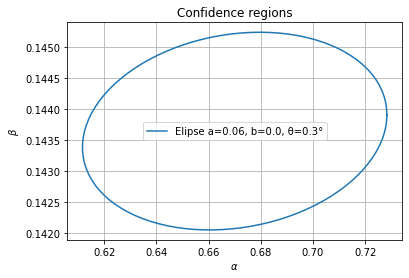

In [ ]:
#alpha = h
#beta = wm
A = 2.3
alpha = 2
beta = 3
# A = 6.18 2 sigma
#A = 11.8  3 sigma
a = A * np.sqrt((0.5 *(C_final[alpha,alpha] + C_final[beta,beta])) + np.sqrt((0.25*((C_final[alpha,alpha] - C_final[beta,beta])**2)) + (C_final[alpha, beta]**2)))
b = A * np.sqrt((0.5 *(C_final[alpha,alpha] + C_final[beta,beta])) - np.sqrt((0.25*((C_final[alpha,alpha] - C_final[beta,beta])**2)) + (C_final[alpha, beta]**2)))
phi = np.radians(0.5 * np.arctan((2* C_final[alpha, beta]) / (C_final[alpha,alpha] - C_final[beta,beta])))

print('phi=', phi)
print('a=', a)
print('b=', b)

plot_ellipse(a, b, phi, center_alpha= h, center_beta= wm)
